# Binary Random Forest Classifier 

Random Forest Classifier Steps: <br>
- Load Main Dataset <br>
- Split in Dataset for training and testing <br>
- Build Bootstrapped Dataset <br>
- Train Decision Trees on those datasets using diferent groups of features<br>
- Get Test Data and for each entry on the table make it go through all the trees and take note of the results<br>
- Agregate all the results from the different trees and choose the best value thorugh majority voting<br>
            


## Library imports

In [ ]:
import pandas as pd
import numpy as np
import math
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from matplotlib import pyplot 

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


#mainpath="C:\\Users\\alexa\\Desktop\\github\\Project-LabIACD\\metadata.csv"
pylidcpath="C:\\Users\\alexa\\Desktop\\Tudo\\Aulas\\LABS\\Project-LabIACD\\csv\\pylidc_grouped.csv"
pyradiomicsPath="C:\\Users\\alexa\\Desktop\\Tudo\\Aulas\\LABS\\Project-LabIACD\\csv\\Dataset_cleared.csv"

## Load Pylidc Dataset

In [25]:
main_dataset=pd.read_csv(pylidcpath)
main_dataset.tail()


,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,Malignancy_round
2646,4.333333,1.0,6.0,3.666667,2.333333,2.333333,3.0,3.333333,4.0,4
2647,2.500000,1.0,6.0,4.500000,2.000000,1.000000,1.5,1.000000,3.5,4
2648,3.000000,1.0,6.0,3.500000,3.500000,1.500000,1.0,5.000000,3.5,4
2649,5.000000,1.0,6.0,4.000000,5.000000,1.000000,1.0,5.000000,2.0,2
2650,5.000000,1.0,4.0,5.000000,5.000000,3.000000,3.0,5.000000,2.5,3


## Spliting Training and Testing Datasets

We are firstly going to make the data division based on Pareto´s Law (80% training/20% testing) <br>

In [26]:
collumn_name='Malignancy_round'
features_collumns=main_dataset.drop(collumn_name,axis=1)
features_collumns=features_collumns.drop('Malignancy',axis=1)
binary=main_dataset[collumn_name].values
for i in range(len(binary)):
    if binary[i]>3:
        binary[i]=1
    else:
        binary[i]=0
main_dataset[collumn_name]=binary
has_cancer_collumns=main_dataset[collumn_name]
features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=0.2)
#has_cancer_collumns
#features_collumns

0       1
1       1
2       0
3       1
4       0
       ..
2646    1
2647    1
2648    1
2649    0
2650    0
Name: Malignancy_round, Length: 2651, dtype: int64

## Random Forest Classifier Pylidc

Although we say in the index that we have to build the Bootstrapped Dataset the sklearn random forest classifier has the ability to do that for us alowing us to skip a step<br>
<br>
In this chapter we´ll have some sub-chapters so that we can play around with the random Forest Classifier to try and get the best possible model


### Default Random Forest

#### DataFitting

In [27]:
RandomForest = RandomForestClassifier()
RandomForest.fit(features_treino,has_cancer_treino)

RandomForestClassifier()

#### Model Evaluation

##### Prediction Part

In [28]:
has_cancer_prediction=RandomForest.predict(features_teste)

##### Accuracy Part

In [29]:
#accuracy= explained_variance_score(has_cancer_teste, has_cancer_prediction)
accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
print(f"Accuracy = {accuracy} in a percentage of 100 = {accuracy*100}")

Accuracy = 0.9077212806026366 in a percentage of 100 = 90.77212806026365


### Model Tuning

Now let's see if by changing the parameters we can get a better solution<br>
<br>
With sklearn we have some comands that help us with this such as RandomizedSearchCV, but let´s first talk about the parameters we'll be messing with:<br>
- n_estimators: Represents the amount of Decision Trees in our Forest, we'll try to change the value in increments of 20 to try and find an "optimal" value between [50,400]<br>
- criterion: criterion in the trees we'll be testing gini vs entropy<br>
- max_features: the number of features that each tree will have, according to some studies the best values should be around $\sqrt{TotalFeatures}$ or log<sub>2</sub>(TotalFeatures)<br>
- min_samples_split: that represents the minimum samples to split a node<br>
- max_depth: in changing this value we can optimize our model and reduce the risk of overfitting

<br>


#### Stackable Improvements Assumption

Note that this is only one proposal of a potential model for this problem where we are going to make some assumptions in order to find if those a are true.
<br>
The first of those is that we'll make the superficial and perhaps stupid assumption that if a parameter improves the accuracy when adjusted by himself that, the improvement is going to stack with the improvement that we get from tuning other parameter by themselfs.<br>
<br>
By the end we'll see if this assumption holds or not

##### Finding the best Tree number

- For this we'll test the tree numbers in increments of 10 <br>
- Our accuracy score for each number of trees will be given by an average of 5 tests <br>
- After this we'll save the best value<br>

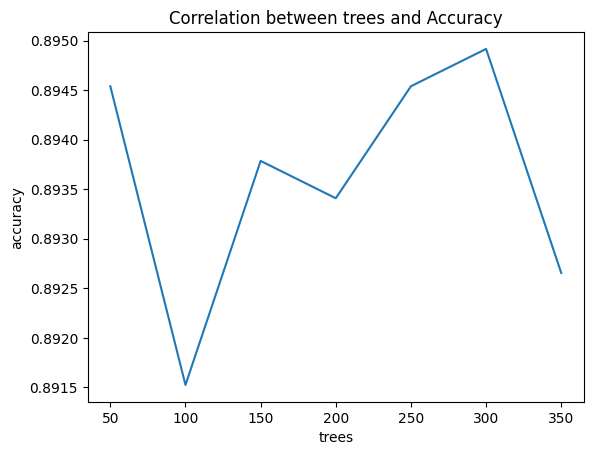

Best tree value=300 accuracy = 0.894915254237288


In [31]:
a=50
b=400
values=[]
treenumber=[]
for i in range (a,b,10):
    average_accuracy=0

    for k in range (5):
        RandomForesttree = RandomForestClassifier(n_estimators=i, n_jobs=(-1))
        RandomForesttree.fit(features_treino,has_cancer_treino)
        has_cancer_predictiontree=RandomForesttree.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_predictiontree)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    treenumber.append(i)

pyplot.plot(treenumber,values )
pyplot.xlabel('trees')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show() 

values=np.array(values)
index=np.where(values==np.max(values))
besttree=treenumber[index[0][0]]
print(f"Best tree value={besttree} accuracy = {np.max(values)}")

##### Finding the best criterion

We'll test three criterion:<br>
- Gini<br>
- Entropy<br>
- Log Loss

In [32]:
accuracy_gini=0
accuracy_entropy=0
accuracy_logloss=0
for i in range (5):
    RandomForestGini = RandomForestClassifier(criterion="gini", n_jobs=(-1))
    RandomForestGini.fit(features_treino,has_cancer_treino)
    has_cancer_predictionGini=RandomForestGini.predict(features_teste)
    accuracy_gini_iter = accuracy_score(has_cancer_teste, has_cancer_predictionGini)
    accuracy_gini+=accuracy_gini_iter

    RandomForestEntropy = RandomForestClassifier(criterion="entropy", n_jobs=(-1))
    RandomForestEntropy.fit(features_treino,has_cancer_treino)
    has_cancer_predictionEntropy=RandomForestEntropy.predict(features_teste)
    accuracy_entropy_iter = accuracy_score(has_cancer_teste, has_cancer_predictionEntropy)
    accuracy_entropy+=accuracy_entropy_iter

    RandomForestlogloss = RandomForestClassifier(criterion="log_loss", n_jobs=(-1))
    RandomForestlogloss.fit(features_treino,has_cancer_treino)
    has_cancer_predictionlogloss=RandomForestlogloss.predict(features_teste)
    accuracy_logloss_iter = accuracy_score(has_cancer_teste, has_cancer_predictionlogloss)
    accuracy_logloss+=accuracy_logloss_iter

accuracy_gini=accuracy_gini/5
accuracy_entropy=accuracy_entropy/5
accuracy_logloss=accuracy_logloss/5

bestcriterionacc=(np.max([accuracy_entropy, accuracy_gini, accuracy_logloss]))
if bestcriterionacc==accuracy_gini:
    bestcriterionname='gini'
if bestcriterionacc==accuracy_entropy:
    bestcriterionname='entropy'
if bestcriterionacc==accuracy_logloss:
    bestcriterionname='log_loss'

In [33]:
print(f"Accuracy Gini = {accuracy_gini} in a percentage of 100 = {accuracy_gini*100}")
print(f"Accuracy Entropy = {accuracy_entropy} in a percentage of 100 = {accuracy_entropy*100}")
print(f"Accuracy Log Loss = {accuracy_logloss} in a percentage of 100 = {accuracy_logloss*100}")
print(f"Best criterion = {bestcriterionname} with an accuracy of = {bestcriterionacc}")

Accuracy Gini = 0.8922787193973635 in a percentage of 100 = 89.22787193973635
Accuracy Entropy = 0.8911487758945386 in a percentage of 100 = 89.11487758945385
Accuracy Log Loss = 0.8915254237288135 in a percentage of 100 = 89.15254237288136
Best criterion = gini with an accuracy of = 0.8922787193973635


##### Finding the best minimum samples split

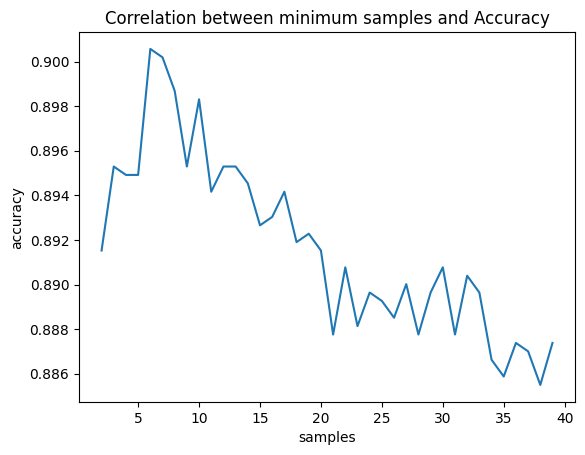

Best Sample value=6, max accuracy=0.9005649717514125


In [34]:
lower=2
upper=40
values=[]
samplesnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForestSamples = RandomForestClassifier(min_samples_split=i, n_jobs=(-1))
        RandomForestSamples.fit(features_treino,has_cancer_treino)
        has_cancer_predictionsamples=RandomForestSamples.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_predictionsamples)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    samplesnumber.append(i)
    
pyplot.plot(samplesnumber,values )
pyplot.xlabel('samples')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between minimum samples and Accuracy')
pyplot.show()


values=np.array(values)
index=np.where(values==np.max(values))
bestsample=samplesnumber[index[0][0]]
print(f"Best Sample value={bestsample}, max accuracy={np.max(values)}")


##### Finding the best Tree deepth

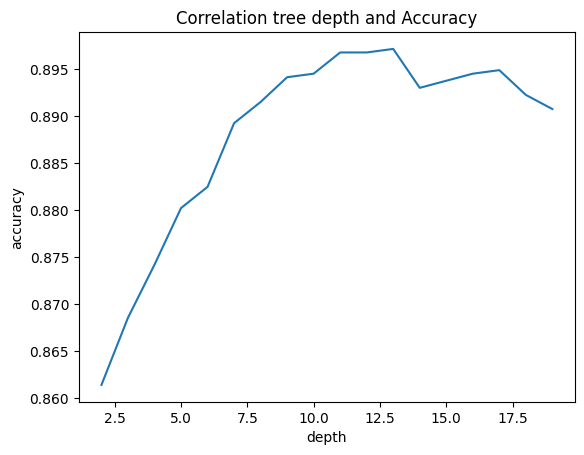

Best depth value=13, max accuracy=0.8971751412429378


In [35]:
lower=2
upper=20
values=[]
depthnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForestdepth = RandomForestClassifier(max_depth=i, n_jobs=(-1))
        RandomForestdepth.fit(features_treino,has_cancer_treino)
        has_cancer_predictiondepth=RandomForestdepth.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_predictiondepth)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    depthnumber.append(i)



pyplot.plot(depthnumber,values )
pyplot.xlabel('depth')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation tree depth and Accuracy')
pyplot.show()

values=np.array(values)
index=np.where(values==np.max(values))
bestdepthnumber=depthnumber[index[0][0]]
print(f"Best depth value={bestdepthnumber}, max accuracy={np.max(values)}")

##### Finding the best Max Features

In this we have two options $\sqrt{TotalFeatures}$ or log<sub>2</sub>(TotalFeatures), that have been shown by studies to be the best two value.<br> But these two values tend to be very similar unless TotalFeatures is a high number. 

In [37]:
accuracy_sqr=0
accuracy_log=0
for i in range (5):
    RandomForestsqr = RandomForestClassifier(max_features='sqrt', n_jobs=(-1))
    RandomForestsqr.fit(features_treino,has_cancer_treino)
    has_cancer_predictionsqr=RandomForestsqr.predict(features_teste)
    accuracy_sqr_iter = accuracy_score(has_cancer_teste, has_cancer_predictionsqr)
    accuracy_sqr+=accuracy_sqr_iter

    RandomForestlog = RandomForestClassifier(max_features='log2', n_jobs=(-1))
    RandomForestlog.fit(features_treino,has_cancer_treino)
    has_cancer_predictionlog=RandomForestlog.predict(features_teste)
    accuracy_log_iter = accuracy_score(has_cancer_teste, has_cancer_predictionlog)
    accuracy_log+=accuracy_log_iter

accuracy_sqr=accuracy_sqr/5
accuracy_log=accuracy_log/5

best_maxsamples_acc=(np.max([accuracy_sqr, accuracy_log,]))
if best_maxsamples_acc==accuracy_sqr:
    best_max_samples_name='sqrt'
if best_maxsamples_acc==accuracy_log:
    best_max_samples_name='log2'

print(f"Accuracy Sqr= {accuracy_sqr} in a percentage of 100 = {accuracy_sqr*100}")
print(f"Accuracy Log= {accuracy_log} in a percentage of 100 = {accuracy_log*100}")
print(f"Difference = {abs(accuracy_log-accuracy_sqr)}")
print(f"Best Max Samples = {best_max_samples_name} with an accuracy of = {best_maxsamples_acc}")

Accuracy Sqr= 0.8934086629001883 in a percentage of 100 = 89.34086629001882
Accuracy Log= 0.8941619585687383 in a percentage of 100 = 89.41619585687383
Difference = 0.0007532956685499803
Best Max Samples = log2 with an accuracy of = 0.8941619585687383


##### Model with "optimal stacking"

In [38]:
accuracy_optimal=0
for i in range(5):
    RandomForestoptimal = RandomForestClassifier(n_estimators=besttree, criterion=bestcriterionname, min_samples_split=bestsample, max_features=bestsample, max_depth=bestdepthnumber, n_jobs=(-1))
    RandomForestoptimal.fit(features_treino,has_cancer_treino)
    has_cancer_predictionoptimal=RandomForestoptimal.predict(features_teste)
    accuracy_optimal_iter = accuracy_score(has_cancer_teste, has_cancer_predictionoptimal)
    accuracy_optimal+=accuracy_optimal_iter
accuracy_optimal=accuracy_optimal/5

print (f"Optimal stacking model accuracy = {accuracy_optimal}")

Optimal stacking model accuracy = 0.9013182674199622


###### Confusion Matrix "optimal stacking"

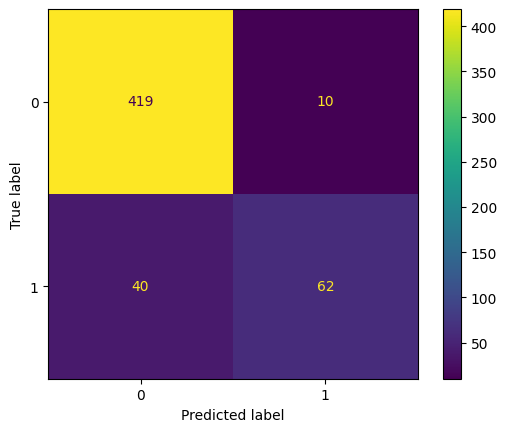

In [39]:
cm=confusion_matrix(has_cancer_teste, has_cancer_predictionoptimal)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

###### First Tree from "optimal stacking" model

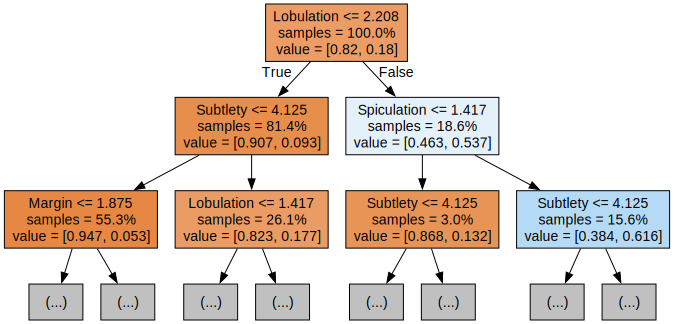

In [40]:
tree = RandomForestoptimal.estimators_[i]
dot_data = export_graphviz(tree,
                            feature_names=features_treino.columns,  
                            filled=True,  
                            max_depth=2, 
                            impurity=False, 
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

#### The computer is Smarter Assumption

Let's now give the computer ability to test diferent parameters at random to find the best parameters<br>
<br>



##### Create the Dictionary for the range of values on the parameters

In [41]:
Range = {'n_estimators': randint(50,500), 
              'max_depth': randint(1,20), 
              'criterion': ['gini', 'entropy', 'log_loss'], 
              'min_samples_split': randint(2,50), 
              'max_features': ['sqrt','log2']
              }

print(Range)

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A1113510>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A0F76750>, 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A0F6A690>, 'max_features': ['sqrt', 'log2']}


##### Random Search

In [47]:
RandomSearch = RandomizedSearchCV(RandomForest, param_distributions = Range, n_iter=5, n_jobs=(-1))


###### Training the Model

In [48]:
RandomSearch.fit(features_treino, has_cancer_treino)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A0F76750>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A0F6A690>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A1113510>})

###### Best parameters found 

In [49]:
Best_Random_Search = RandomSearch.best_estimator_
print('Best hyperparameters:',  RandomSearch.best_params_)

Best hyperparameters: {'criterion': 'log_loss', 'max_depth': 17, 'max_features': 'log2', 'min_samples_split': 8, 'n_estimators': 432}


###### Accuracy of this model

In [50]:
has_cancer_prediction_BestRandomSearch = Best_Random_Search.predict(features_teste)
accuracy_BestRandomSearch = accuracy_score(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
print(accuracy_BestRandomSearch)

0.903954802259887


###### Confusion Matrix

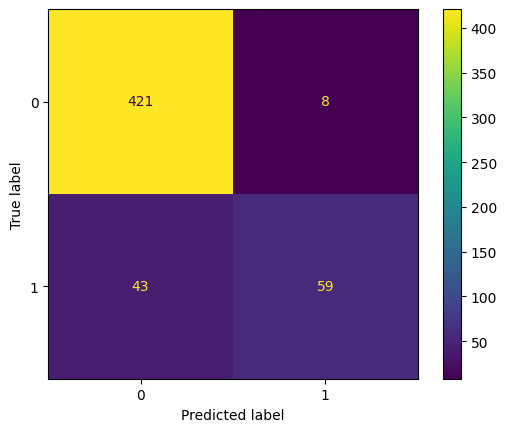

In [51]:
cmrandom=confusion_matrix(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
ConfusionMatrixDisplay(confusion_matrix=cmrandom).plot()

## Load Pyradiomics Dataset

In [71]:
main_dataset=pd.read_csv(pyradiomicsPath)
main_dataset.tail()

,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,...,Volume,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
2646,0.375133,4.534490,12.087678,12.806248,11.401754,13.928388,14.628739,313.083333,9.595771,0.664923,...,140.178680,4.333333,1.0,6.0,3.666667,2.333333,2.333333,3.0,3.333333,4.0
2647,0.687954,8.589183,12.485120,14.422205,14.317821,12.649111,15.165751,605.541667,9.416961,0.697558,...,182.381630,2.500000,1.0,6.0,4.500000,2.000000,1.000000,1.5,1.000000,4.0
2648,0.185778,2.586515,13.922612,11.045361,14.866069,12.165525,15.842980,177.541667,7.855304,0.597379,...,127.207670,3.000000,1.0,6.0,3.500000,3.500000,1.500000,1.0,5.000000,4.0
2649,0.247844,2.471175,9.970706,7.280110,7.211103,7.615773,10.440307,70.041667,4.521458,0.708770,...,81.383582,5.000000,1.0,6.0,4.000000,5.000000,1.000000,1.0,5.000000,2.0
2650,0.273192,11.674262,42.732887,49.040799,50.219518,46.097722,51.048996,13760.916667,38.858918,0.635278,...,25205.225767,5.000000,1.0,4.0,5.000000,5.000000,3.000000,3.0,5.000000,2.0


## Random Forest Classifier Pyradiomics

Let's now test the theory that if we had more features it would be better, as we proposed in the Pylidc part of this notebook.<br>
With Pyradiomics we were able to extract about 100 features to train our model.<br>

### Data Split 1

In [52]:
features_collumns=main_dataset.drop('Malignancy',axis=1)
has_cancer_collumns=main_dataset['Malignancy']
binary=main_dataset['Malignancy'].values
for i in range(len(binary)):
    if binary[i]>3:
        binary[i]=1
    else:
        binary[i]=0
main_dataset[collumn_name]=binary
has_cancer_collumns=main_dataset[collumn_name]

features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=0.2)

### Random Forest Pyradiomics 1

We will be doing two random forests for pyradiomics<br>
The first we will use to get an estimate of the maximum complexity of one tree in a forest for the second data split

#### Random Search and data fitting

In [53]:
RandomSearch = RandomizedSearchCV(RandomForest, param_distributions = Range, n_iter=5, n_jobs=(-1))
RandomSearch.fit(features_treino, has_cancer_treino)
Best_Random_Search = RandomSearch.best_estimator_
print('Best hyperparameters:',  RandomSearch.best_params_)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 300}


#### Accuracy

In [54]:
has_cancer_prediction_BestRandomSearch = Best_Random_Search.predict(features_teste)
accuracy_BestRandomSearch = accuracy_score(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
print(accuracy_BestRandomSearch)

0.9510357815442562


#### Confusion Matrix

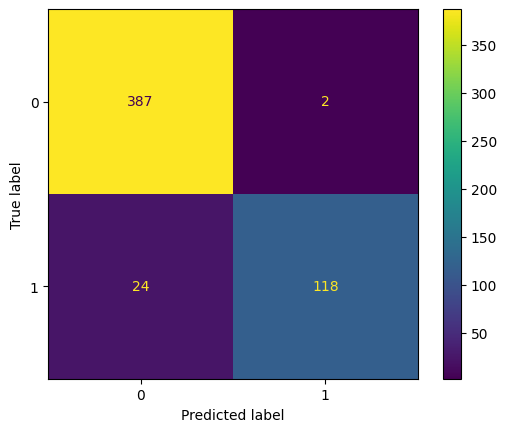

In [55]:
cmrandom=confusion_matrix(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
ConfusionMatrixDisplay(confusion_matrix=cmrandom).plot()

### Data Split 2

We'll use the "A scaling law
for the validation-set training-set size ratio" paper by Isabelle Guyon findings to try and optimize our data split or an adaptation of the findings to our case.<br>
In the paper it's said that the best split is given by $\sqrt{}$ ln($\frac{N}{hmax}$)<br>
N beeing the number of families of recognizers in an finite H<br>
hmax beeing the largest complexity of those families<br>
<br>

So for our random forest we are going to do a small adaptation in the hopes that it improves the accuracy:<br>
- N is going to be the number of trees in the forest<br>
- hmax the complexity of the trees.<br>
<br>
We'll use the tree from pyradiomics random forest 1 to make the calculations<br>


#### Setting N

In [56]:
N=RandomSearch.best_params_['n_estimators']
print(N)

300


#### Setting hmax

The complexity of one tree is determined by bigO(tkd) beeing:<br>
- t: number training examples<br>
- k: number of features<br>
- d: depth of decision tree<br>


In [57]:
t=RandomSearch.best_params_['min_samples_split']
if (RandomSearch.best_params_['max_features']=='sqrt'):
    k=math.sqrt(117)
else:
    k=math.log(117)

d=RandomSearch.best_params_['max_depth']


hmax=t*k*d
hmax=hmax
print (f"hmax={hmax} t={t} k={k} d={d}")

hmax=1038.398767333629 t=6 k=10.816653826391969 d=16


#### Setting $\sqrt{}$ ln($\frac{N}{hmax}$)

In [58]:
result=N/hmax*100000
result=math.trunc(result)/100000
print(result)
log=abs(math.log(result))
print(log)
split=math.sqrt(result)
print(split)

0.2889
1.2416746715099476
0.5374941860150675


#### Spliting with new split value

In [59]:
features_collumns=main_dataset.drop('Malignancy',axis=1)
has_cancer_collumns=main_dataset['Malignancy']

features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=split)

### Random Forest Pyradiomics 2

#### Random Forest with same hyperparameters

In [60]:
RandomSearch.fit(features_treino, has_cancer_treino)


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A0F76750>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A0F6A690>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000213A1113510>})

#### Accuracy

In [61]:
has_cancer_prediction_BestRandomSearch = Best_Random_Search.predict(features_teste)
accuracy_BestRandomSearch = accuracy_score(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
print(accuracy_BestRandomSearch)

0.9992982456140351


#### Confusion Matrix

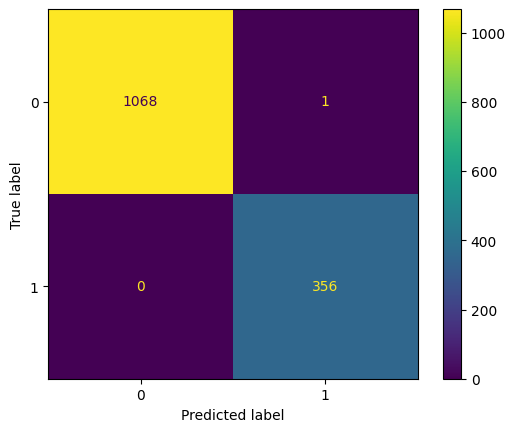

In [62]:
cmrandom=confusion_matrix(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
ConfusionMatrixDisplay(confusion_matrix=cmrandom).plot()